# HECO validation test
---
## Climate condition analysis

this notebook is used to plot rosediagram and map for a characterization of climate condition at the location and date used for the validation test.
-> East mediterranean sea in the date 2021-07-23 to 2021-08-12, accordin to the study conducted about the oil spills that occurred at the Syrian Baniyas Station in the Eastern Mediterranean on August 23, 2021 (DOI: 10.1016/j.marpolbul.2023.115887).

In [1]:
import sys
print(sys.version)
import ipykernel
print(ipykernel.get_connection_file())

3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]
/Users/gianfrancodipietro/Library/Jupyter/runtime/kernel-v36341a95d0aa9be633b95637ca8562701f6619e24.json


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import pandas as pd
import numpy as np
import os
import sys
import copernicusmarine
import windrose
import warnings
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import ssl
import reportlab


In [ ]:
from reportlab.lib.pagesizes import A4, inch
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import BaseDocTemplate, PageTemplate, Frame, Paragraph, Table, Image, PageBreak
from reportlab.platypus import Image as ResizeImage
from reportlab.lib.utils import ImageReader
from io import BytesIO


# 1. EU CMSES Datset access

Mediterranean Sea Physics Reanalysis
> Currents, hourly

`med-cmcc-cur-rean-h`

<details><summary> The Med MFC physical multiyear product is generated bya numerical system composed of an hydrodynamic model, supplied by the Nucleous for European Modelling of the Ocean (NEMO) and a variational data assimilation scheme (OceanVAR) for temperature and salinity vertical profiles and satellite Sea Level Anomaly along track data.  </summary> It contains a reanalysis dataset and an interim dataset which covers the period after the reanalysis until 1 month before present. The model horizontal grid resolution is 1/24˚ (ca. 4-5 km) and the unevenly spaced vertical levels are 141.

DOI (Product): https://doi.org/10.25423/CMCC/MEDSEA_MULTIYEAR_PHY_006_004_E3R1

DOI (Interim dataset): https://doi.org/10.25423/CMCC/MEDSEA_MULTIYEAR_PHY_006_004_E3R1I

References:

- Escudier, R., Clementi, E., Omar, M., Cipollone, A., Pistoia, J., Aydogdu, A., Drudi, M., Grandi, A., Lyubartsev, V., Lecci, R., Cretí, S., Masina, S., Coppini, G., & Pinardi, N. (2020). Mediterranean Sea Physical Reanalysis (CMEMS MED-Currents) (Version 1) [Data set]. Copernicus Monitoring Environment Marine Service (CMEMS). https://doi.org/10.25423/CMCC/MEDSEA_MULTIYEAR_PHY_006_004_E3R1
- Escudier, R., Clementi, E., Cipollone, A., Pistoia, J., Drudi, M., Grandi, A., Lyubartsev, V., Lecci, R., Aydogdu, A., Delrosso, D., Omar, M., Masina, S., Coppini G., Pinardi, N. (2021). A High Resolution Reanalysis for the Mediterranean Sea. Frontiers in Earth Science, 9, 1060, https://www.frontiersin.org/article/10.3389/feart.2021.702285, DOI=10.3389/feart.2021.702285
- Nigam, T., Escudier, R., Pistoia, J., Aydogdu, A., Omar, M., Clementi, E., Cipollone, A., Drudi, M., Grandi, A., Mariani, A., Lyubartsev, V., Lecci, R., Cretí, S., Masina, S., Coppini, G., & Pinardi, N. (2021). Mediterranean Sea Physical Reanalysis INTERIM (CMEMS MED-Currents, E3R1i system) (Version 1) [Data set]. Copernicus Monitoring Environment Marine Service (CMEMS). https://doi.org/10.25423/CMCC/MEDSEA_MULTIYEAR_PHY_006_004_E3R1I
</details>


<div style="padding: 10px; border: 1px solid orange; background-color: #fff3cd; color: #856404; border-radius: 5px;">
  <strong>Use CMSES Credenzials</strong> For send an API call with copernicusmarine function is mandatory use the credential provided by marine.copernicus.eu
</div>
More info about `copernicusmarine` API --> [link](https://help.marine.copernicus.eu/en/articles/8287609-copernicus-marine-toolbox-api-open-a-dataset-or-read-a-dataframe-remotely)

In [3]:
## Parameters

CMSESrequest = {
    "datasetID": "med-cmcc-cur-rean-h",
    "lat-slice": [34.6, 36.70],
    "lon-slice": [33.7, 36.11],
    "time-slice": ["2021-08-25", "2021-09-10"], # from 29-Aug-2021 16:36 to 30-Aug-2021 10:58
    "variables": ["uo", "vo"]
}

# Access to the dataset (Xarray)
DS = copernicusmarine.open_dataset(
    dataset_id=CMSESrequest["datasetID"],
    minimum_longitude=CMSESrequest["lon-slice"][0],
    maximum_longitude=CMSESrequest["lon-slice"][1],
    minimum_latitude=CMSESrequest["lat-slice"][0],
    maximum_latitude=CMSESrequest["lat-slice"][1],
    start_datetime=CMSESrequest["time-slice"][0],
    end_datetime=CMSESrequest["time-slice"][1],
    variables=CMSESrequest["variables"]
)



Fetching catalog:   0%|          | 0/4 [00:00<?, ?it/s]

WARNING - 2025-07-28T13:43:58Z - Failed to parse portal catalogue: 'services'. Only using stac catalogue.


Fetching catalog: 100%|██████████| 4/4 [01:16<00:00, 19.01s/it]


INFO - 2025-07-28T13:45:13Z - Dataset version was not specified, the latest one was selected: "202012"
INFO - 2025-07-28T13:45:13Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2025-07-28T13:46:26Z - Service was not specified, the default one was selected: "arco-geo-series"
username:password:

In [4]:
DS

<xarray.Dataset>
Dimensions:    (time: 385, latitude: 51, longitude: 58)
Coordinates:
  * latitude   (latitude) float32 34.6 34.65 34.69 34.73 ... 36.6 36.65 36.69
  * longitude  (longitude) float32 33.71 33.75 33.79 33.83 ... 36.0 36.04 36.08
  * time       (time) datetime64[ns] 2021-08-25 ... 2021-09-10
Data variables:
    uo         (time, latitude, longitude) float32 ...
    vo         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:    CF-1.0
    bulletin_date:  20200901
    bulletin_type:  reanalysis
    comment:        Please check in CMEMS catalogue the INFO section for prod...
    contact:        servicedesk.cmems@mercator-ocean.eu
    field_type:     hourly_mean_centered_at_time_field
    institution:    Centro Euro-Mediterraneo sui Cambiamenti Climatici - CMCC...
    references:     Please check in CMEMS catalogue the INFO section for prod...
    source:         MFS E3R1
    title:          Horizontal Surface Velocity (2D) - Hourly Mean

In [ ]:
#subset using nearest method point
import warnings

DS_subset = DS.sel(longitude=34.956, latitude=35.371, method="nearest")

if np.any(np.isnan(DS_subset.uo.values)):
    warnings.warn("No data available for the selected ROI")


/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/y3/31vwk74d2xv464bxpc17c_280000gn/T/ipykernel_2561/325578370.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottora

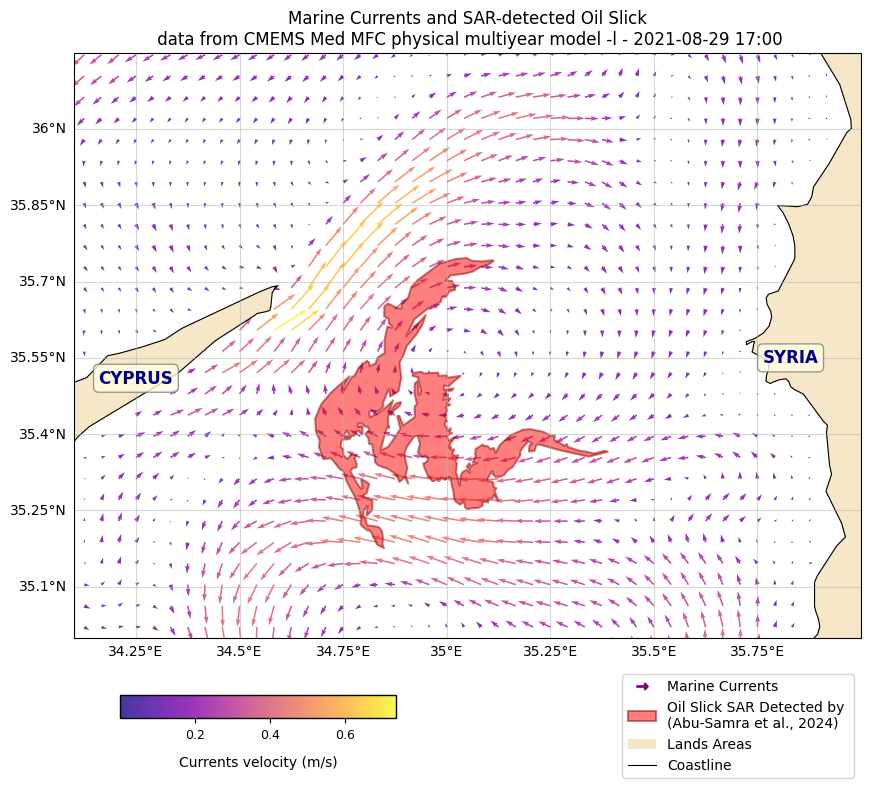

In [104]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# find the nearest time step 
target_time = '2021-08-29T16:36'
ds_plot = DS.sel(time=target_time, method='nearest')
time_step = ds_plot.time


# Plot vectors
magnitude = np.sqrt(ds_plot.uo**2 + ds_plot.vo**2)
quiver = ax.quiver(
    ds_plot.longitude.values, 
    ds_plot.latitude.values,
    ds_plot.uo.values, 
    ds_plot.vo.values,
    magnitude.values,  #magnitude color value
    scale=15,
    width=0.002,
    cmap='plasma',  # 'plasma', 'inferno', 'turbo'
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# vector colorbar with custom position outside the map, left-aligned 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax, 
                 width="35%",     
                 height="4%",    
                 loc='lower left', 
                 bbox_to_anchor=(0.05, -0.15, 1, 1),  # (x, y, width, height)
                 bbox_transform=ax.transAxes)
# draw white box on cax
cax.set_facecolor('white')
cax.set_alpha(1)

cbar = plt.colorbar(quiver, cax=cax, orientation='horizontal')
cbar.set_label('Currents velocity (m/s)', rotation=0, labelpad=10, fontsize=10)
cbar.ax.tick_params(labelsize=9)
cbar.outline.set_linewidth(1)
cbar.outline.set_edgecolor('black')
# # patch
# cax.patch.set_facecolor('white')
# cax.patch.set_alpha(1)
# cax.patch.set_edgecolor('gray')
# cax.patch.set_linewidth(0.5)
cbar.fancybox = True
cbar.shadow = True


# add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
#add land polygon
ax.add_feature(cfeature.LAND, color='wheat', alpha=0.7)

# State labels (manually located)
labels = {
    'CYPRUS': (34.25, 35.51),
    'SYRIA': (35.83, 35.55),
}

for country, (lon, lat) in labels.items():
    ax.text(lon, lat, country,
            transform=ccrs.PlateCarree(),
            fontsize=12, fontweight='bold', color='darkblue',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8, edgecolor='gray'))


# ax.add_feature(cfeature.OCEAN, color='azure', alpha=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
# ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7)
# ax.add_feature(cfeature.RIVERS, color='blue', linewidth=0.3)

# 
ax.set_title(f'Marine Currents and SAR-detected Oil Slick\n data from CMEMS Med MFC physical multiyear model -l - {time_step.dt.strftime("%Y-%m-%d %H:%M").values}')
# ax.set_xlabel('Longitudine')
# ax.set_ylabel('Latitudine')
ax.set_xlim(34.1, 36.0)  # Longitudine
ax.set_ylim(35.0, 36.15)  # Latitudine
#Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add GeoJson overlay
geojson_path = 'results/qgis_comparison/29-AUG-2021-AbouSamra-and-Ai-2024-oilspill-SAR-detection.geojson'
gdf = gpd.read_file(geojson_path)
gdf.plot(ax=ax, facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5, transform=ccrs.PlateCarree())

# ax.legend()
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='$\\rightarrow$', color='purple', label='Marine Currents',
           markerfacecolor='purple', markersize=8, linestyle='None'),
    Patch(facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5,
          label='Oil Slick SAR Detected by \n(Abu-Samra et al., 2024)'),
    Patch(facecolor='wheat', alpha=0.7, label='Lands Areas'),
    Line2D([0], [0], color='black', linewidth=0.8, label='Coastline')
]

# add legend
legend = ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(1.0, -0.05), frameon=True, 
          fancybox=True, shadow=False, fontsize=10)

plt.tight_layout()
plt.savefig('results/marine_currents_oil_slick_map_origin_SAR-detected.png', dpi=300, bbox_inches='tight')
plt.show()

/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/y3/31vwk74d2xv464bxpc17c_280000gn/T/ipykernel_2561/1062540534.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottor

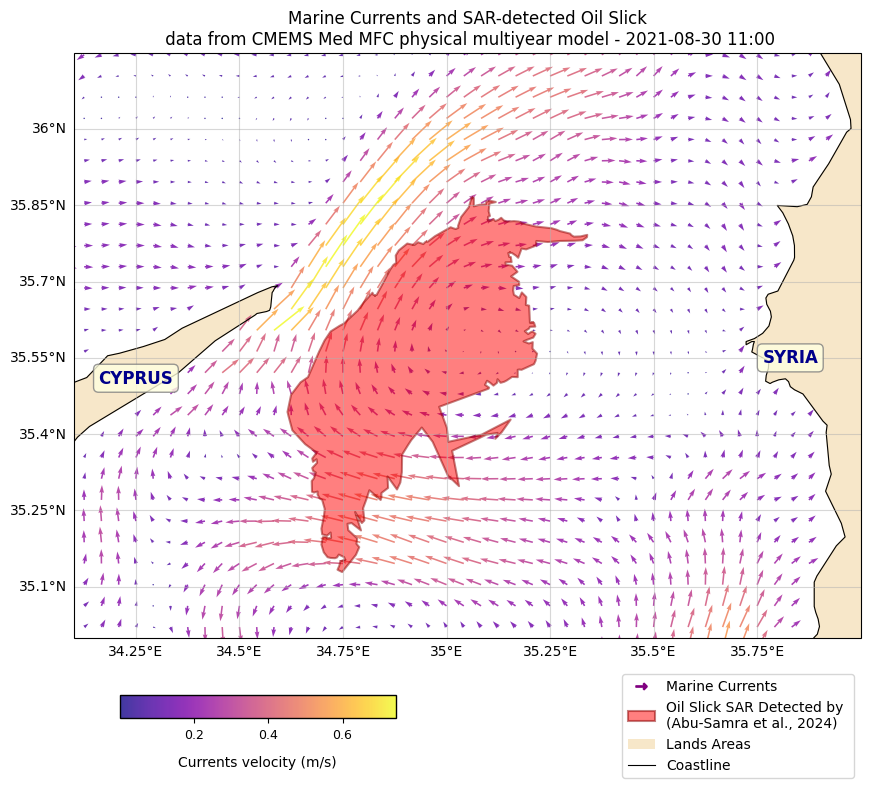

In [105]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# find the nearest time step 
target_time = '2021-08-30T10:58'
ds_plot = DS.sel(time=target_time, method='nearest')
time_step = ds_plot.time


# Plot vectors
magnitude = np.sqrt(ds_plot.uo**2 + ds_plot.vo**2)
quiver = ax.quiver(
    ds_plot.longitude.values, 
    ds_plot.latitude.values,
    ds_plot.uo.values, 
    ds_plot.vo.values,
    magnitude.values,  #magnitude color value
    scale=15,
    width=0.002,
    cmap='plasma',  # 'plasma', 'inferno', 'turbo'
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# vector colorbar with custom position outside the map, left-aligned 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax, 
                 width="35%",     
                 height="4%",    
                 loc='lower left', 
                 bbox_to_anchor=(0.05, -0.15, 1, 1),  # (x, y, width, height)
                 bbox_transform=ax.transAxes)
# draw white box on cax
cax.set_facecolor('white')
cax.set_alpha(1)

cbar = plt.colorbar(quiver, cax=cax, orientation='horizontal')
cbar.set_label('Currents velocity (m/s)', rotation=0, labelpad=10, fontsize=10)
cbar.ax.tick_params(labelsize=9)
cbar.outline.set_linewidth(1)
cbar.outline.set_edgecolor('black')
# # patch
# cax.patch.set_facecolor('white')
# cax.patch.set_alpha(1)
# cax.patch.set_edgecolor('gray')
# cax.patch.set_linewidth(0.5)
cbar.fancybox = True
cbar.shadow = True


# add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
#add land polygon
ax.add_feature(cfeature.LAND, color='wheat', alpha=0.7)

# State labels (manually located)
labels = {
    'CYPRUS': (34.25, 35.51),
    'SYRIA': (35.83, 35.55),
}

for country, (lon, lat) in labels.items():
    ax.text(lon, lat, country,
            transform=ccrs.PlateCarree(),
            fontsize=12, fontweight='bold', color='darkblue',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8, edgecolor='gray'))


# ax.add_feature(cfeature.OCEAN, color='azure', alpha=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
# ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7)
# ax.add_feature(cfeature.RIVERS, color='blue', linewidth=0.3)

# 
ax.set_title(f'Marine Currents and SAR-detected Oil Slick\n data from CMEMS Med MFC physical multiyear model - {time_step.dt.strftime("%Y-%m-%d %H:%M").values}')
# ax.set_xlabel('Longitudine')
# ax.set_ylabel('Latitudine')
ax.set_xlim(34.1, 36.0)  # Longitudine
ax.set_ylim(35.0, 36.15)  # Latitudine
#Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add GeoJson overlay
geojson_path = 'results/qgis_comparison/30-AUG-2021-AbouSamra-and-Ai-2024-oilspill-SAR-detection.geojson'
gdf = gpd.read_file(geojson_path)
gdf.plot(ax=ax, facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5, transform=ccrs.PlateCarree())

# ax.legend()
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='$\\rightarrow$', color='purple', label='Marine Currents',
           markerfacecolor='purple', markersize=8, linestyle='None'),
    Patch(facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5,
          label='Oil Slick SAR Detected by \n(Abu-Samra et al., 2024)'),
    Patch(facecolor='wheat', alpha=0.7, label='Lands Areas'),
    Line2D([0], [0], color='black', linewidth=0.8, label='Coastline')
]

# add legend
legend = ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(1.0, -0.05), frameon=True, 
          fancybox=True, shadow=False, fontsize=10)

plt.tight_layout()
plt.savefig('results/marine_currents_oil_slick_map_endtime_SAR-detected.png', dpi=300, bbox_inches='tight')
plt.show()

/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/y3/31vwk74d2xv464bxpc17c_280000gn/T/ipykernel_2561/1404291538.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottor

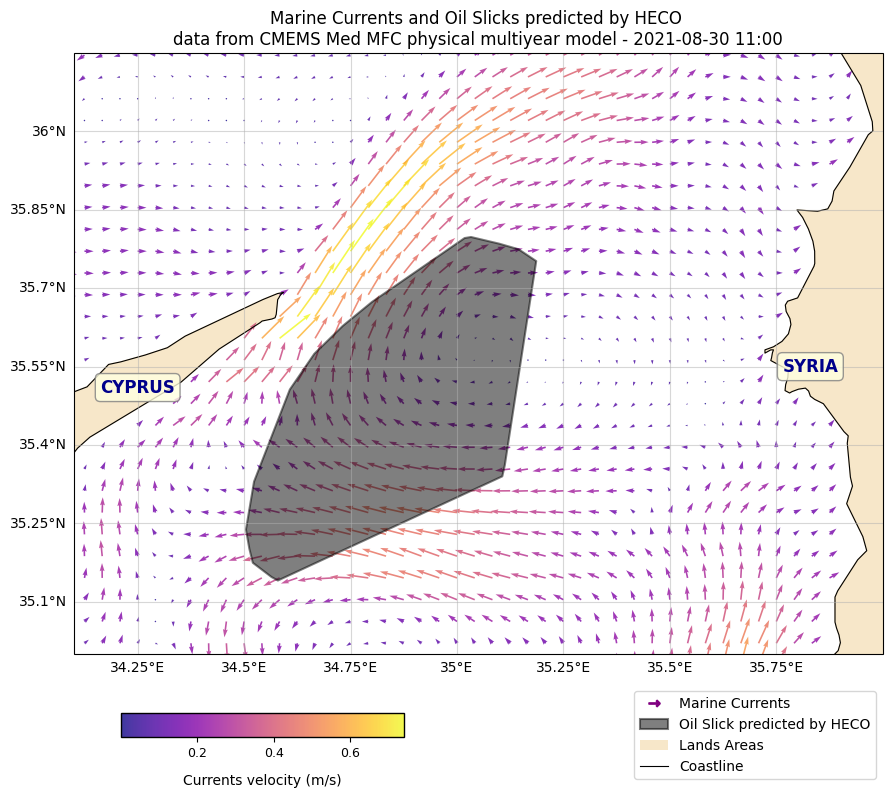

In [106]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# find the nearest time step 
target_time = '2021-08-30T10:58'
ds_plot = DS.sel(time=target_time, method='nearest')
time_step = ds_plot.time


# Plot vectors
magnitude = np.sqrt(ds_plot.uo**2 + ds_plot.vo**2)
quiver = ax.quiver(
    ds_plot.longitude.values, 
    ds_plot.latitude.values,
    ds_plot.uo.values, 
    ds_plot.vo.values,
    magnitude.values,  #magnitude color value
    scale=15,
    width=0.002,
    cmap='plasma',  # 'plasma', 'inferno', 'turbo'
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# vector colorbar with custom position outside the map, left-aligned 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax, 
                 width="35%",     
                 height="4%",    
                 loc='lower left', 
                 bbox_to_anchor=(0.05, -0.15, 1, 1),  # (x, y, width, height)
                 bbox_transform=ax.transAxes)
# draw white box on cax
cax.set_facecolor('white')
cax.set_alpha(1)

cbar = plt.colorbar(quiver, cax=cax, orientation='horizontal')
cbar.set_label('Currents velocity (m/s)', rotation=0, labelpad=10, fontsize=10)
cbar.ax.tick_params(labelsize=9)
cbar.outline.set_linewidth(1)
cbar.outline.set_edgecolor('black')
# # patch
# cax.patch.set_facecolor('white')
# cax.patch.set_alpha(1)
# cax.patch.set_edgecolor('gray')
# cax.patch.set_linewidth(0.5)
cbar.fancybox = True
cbar.shadow = True


# add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
#add land polygon
ax.add_feature(cfeature.LAND, color='wheat', alpha=0.7)

# State labels (manually located)
labels = {
    'CYPRUS': (34.25, 35.51),
    'SYRIA': (35.83, 35.55),
}

for country, (lon, lat) in labels.items():
    ax.text(lon, lat, country,
            transform=ccrs.PlateCarree(),
            fontsize=12, fontweight='bold', color='darkblue',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8, edgecolor='gray'))


# ax.add_feature(cfeature.OCEAN, color='azure', alpha=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
# ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7)
# ax.add_feature(cfeature.RIVERS, color='blue', linewidth=0.3)

# 
ax.set_title(f'Marine Currents and Oil Slicks predicted by HECO \ndata from CMEMS Med MFC physical multiyear model - {time_step.dt.strftime("%Y-%m-%d %H:%M").values}')
# ax.set_xlabel('Longitudine')
# ax.set_ylabel('Latitudine')
ax.set_xlim(34.1, 36.0)  # Longitudine
ax.set_ylim(35.0, 36.15)  # Latitudine
#Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add GeoJson overlay
geojson_path = 'results/qgis_comparison/convex-hull-polygon-TEST-2-2021-08-30_10-36.geojson'
gdf = gpd.read_file(geojson_path)
gdf.plot(ax=ax, facecolor='black', edgecolor='black', alpha=0.5, linewidth=1.5, transform=ccrs.PlateCarree())

# ax.legend()
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='$\\rightarrow$', color='purple', label='Marine Currents',
           markerfacecolor='purple', markersize=8, linestyle='None'),
    Patch(facecolor='black', edgecolor='black', alpha=0.5, linewidth=1.5,
          label='Oil Slick predicted by HECO'),
    Patch(facecolor='wheat', alpha=0.7, label='Lands Areas'),
    Line2D([0], [0], color='black', linewidth=0.8, label='Coastline')
]

# add legend
legend = ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(1.0, -0.05), frameon=True, 
          fancybox=True, shadow=False, fontsize=10)

plt.tight_layout()
plt.savefig('results/marine_currents_oil_slick_map_endtime-HECO-predicted.png', dpi=300, bbox_inches='tight')
plt.show()

/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/y3/31vwk74d2xv464bxpc17c_280000gn/T/ipykernel_2561/1401283928.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Volumes/LaCie/000 - Dottorato UNICT/seaquest_team/HECO/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/LaCie/000 - Dottor

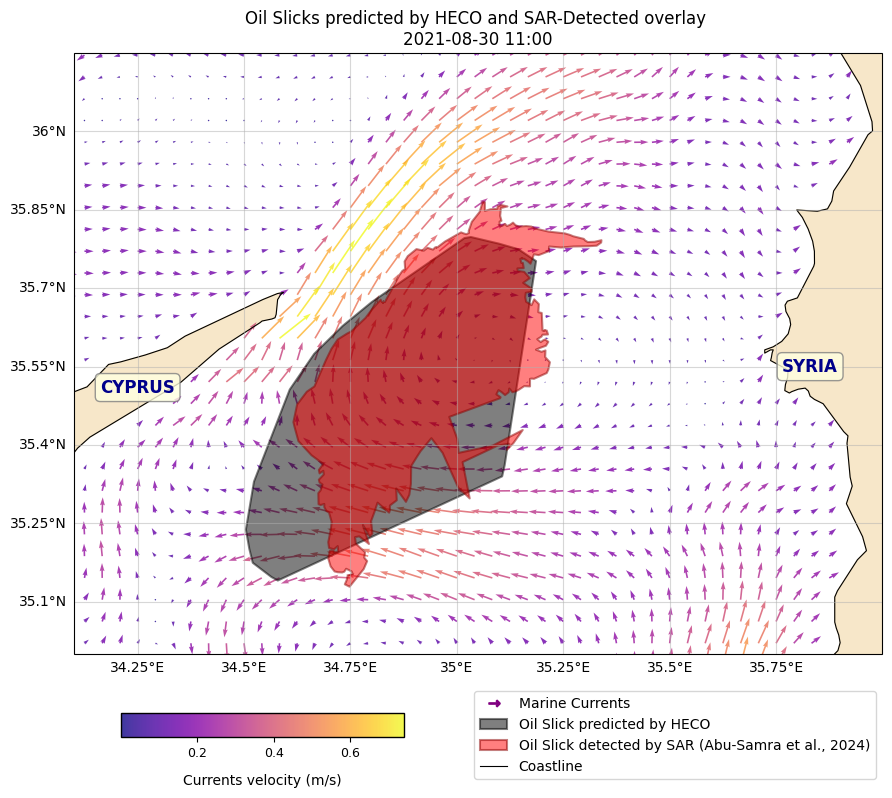

In [ ]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# find the nearest time step 
target_time = '2021-08-30T10:58'
ds_plot = DS.sel(time=target_time, method='nearest')
time_step = ds_plot.time


# Plot vectors
magnitude = np.sqrt(ds_plot.uo**2 + ds_plot.vo**2)
quiver = ax.quiver(
    ds_plot.longitude.values, 
    ds_plot.latitude.values,
    ds_plot.uo.values, 
    ds_plot.vo.values,
    magnitude.values,  #magnitude color value
    scale=15,
    width=0.002,
    cmap='plasma',  # 'plasma', 'inferno', 'turbo'
    alpha=0.8,
    transform=ccrs.PlateCarree()
)

# vector colorbar with custom position outside the map, left-aligned 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax, 
                 width="35%",     
                 height="4%",    
                 loc='lower left', 
                 bbox_to_anchor=(0.05, -0.15, 1, 1),  # (x, y, width, height)
                 bbox_transform=ax.transAxes)
# draw white box on cax
cax.set_facecolor('white')
cax.set_alpha(1)

cbar = plt.colorbar(quiver, cax=cax, orientation='horizontal')
cbar.set_label('Currents velocity (m/s)', rotation=0, labelpad=10, fontsize=10)
cbar.ax.tick_params(labelsize=9)
cbar.outline.set_linewidth(1)
cbar.outline.set_edgecolor('black')
# # patch
# cax.patch.set_facecolor('white')
# cax.patch.set_alpha(1)
# cax.patch.set_edgecolor('gray')
# cax.patch.set_linewidth(0.5)
cbar.fancybox = True
cbar.shadow = True


# add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, color='black')
#add land polygon
ax.add_feature(cfeature.LAND, color='wheat', alpha=0.7)

# State labels (manually located)
labels = {
    'CYPRUS': (34.25, 35.51),
    'SYRIA': (35.83, 35.55),
}

for country, (lon, lat) in labels.items():
    ax.text(lon, lat, country,
            transform=ccrs.PlateCarree(),
            fontsize=12, fontweight='bold', color='darkblue',
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8, edgecolor='gray'))


# ax.add_feature(cfeature.OCEAN, color='azure', alpha=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5, color='gray')
# ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7)
# ax.add_feature(cfeature.RIVERS, color='blue', linewidth=0.3)

# 
ax.set_title(f'Oil Slicks predicted by HECO and SAR-Detected overlay \n{time_step.dt.strftime("%Y-%m-%d %H:%M").values}')

ax.set_xlim(34.1, 36.0)  # Long
ax.set_ylim(35.0, 36.15)  # Lat
#Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add GeoJson#1 overlay
geojson_path = 'results/qgis_comparison/convex-hull-polygon-TEST-2-2021-08-30_10-36.geojson'
gdf = gpd.read_file(geojson_path)
gdf.plot(ax=ax, facecolor='black', edgecolor='black', alpha=0.5, linewidth=1.5, transform=ccrs.PlateCarree())

# Add GeoJson#2 overlay
geojson_path = 'results/qgis_comparison/30-AUG-2021-AbouSamra-and-Ai-2024-oilspill-SAR-detection.geojson'
gdf = gpd.read_file(geojson_path)
gdf.plot(ax=ax, facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5, transform=ccrs.PlateCarree())


# ax.legend()
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='$\\rightarrow$', color='purple', label='Marine Currents',
           markerfacecolor='purple', markersize=8, linestyle='None'),
    Patch(facecolor='black', edgecolor='black', alpha=0.5, linewidth=1.5,
          label='Oil Slick predicted by HECO'),
    Patch(facecolor='red', edgecolor='darkred', alpha=0.5, linewidth=1.5,
          label='Oil Slick detected by SAR (Abu-Samra et al., 2024)'),
    Line2D([0], [0], color='black', linewidth=0.8, label='Coastline')
]

# add legend
legend = ax.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(1.0, -0.05), frameon=True, 
          fancybox=True, shadow=False, fontsize=10)

plt.tight_layout()
plt.savefig('results/marine_currents_oil_slick_map_HECO-SAR-overlay.png', dpi=300, bbox_inches='tight')
plt.show()